# RainFall Predictor - Logistic vs RandomForest

# Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
path = '../data/weatherAUS.csv'
df = pd.read_csv(path)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# check for missing values
df.count()

Date             145460
Location         145460
MinTemp          143975
MaxTemp          144199
Rainfall         142199
Evaporation       82670
Sunshine          75625
WindGustDir      135134
WindGustSpeed    135197
WindDir9am       134894
WindDir3pm       141232
WindSpeed9am     143693
WindSpeed3pm     142398
Humidity9am      142806
Humidity3pm      140953
Pressure9am      130395
Pressure3pm      130432
Cloud9am          89572
Cloud3pm          86102
Temp9am          143693
Temp3pm          141851
RainToday        142199
RainTomorrow     142193
dtype: int64

In [4]:
# drop missing values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

* 56420 observations still

In [5]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

* Adjust approach to predict whether it will rain today. 
    * Can use historical weather data up to and including yesterday
    * Update name in the columns accordinly

In [6]:
df = df.rename(columns={
    'RainTomorrow': 'RainToday',
    'RainToday': 'RainYesterday'
    })

# Location selection
* Weather patterns are different depending on the location
* Group close cities in "Location" by distance
* Filter df to Melbourne, Melbourne Airport, Watsonia (theyre close)


In [7]:
# filter for specific locations
df = df[df.Location.isin(['Melbourne', 'MelbourneAirport', 'Watsonia'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

* 7557 observations still

# Season mapping

* Weather patterns are usually seasonal 
* Create "Seasons" from "Date"

In [8]:
def date_to_season(date):
    month = date.month
    if (month == 12) or (month == 1) or (month == 2):
        return 'Summer'
    elif (month == 3) or (month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6) or (month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9) or (month == 10) or (month == 11):
        return 'Spring'

In [9]:
# convert "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# apply function to create Season column
df['Season'] = df['Date'].apply(date_to_season)

# drop date column; we will use season instead
df=df.drop(columns=['Date'])
df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80992,Watsonia,3.6,14.5,0.0,2.4,8.8,NNE,41.0,ENE,NNE,...,66.0,1028.4,1025.0,1.0,7.0,5.2,13.8,No,No,Winter
80994,Watsonia,4.8,13.3,0.4,0.6,0.0,NNW,24.0,NE,NNE,...,63.0,1028.5,1025.1,7.0,7.0,5.6,12.4,No,No,Winter
80995,Watsonia,5.6,13.1,0.0,1.6,6.0,NNW,52.0,NE,N,...,67.0,1019.0,1014.0,1.0,7.0,8.8,11.6,No,Yes,Winter
80996,Watsonia,6.9,12.1,3.2,1.8,5.6,SSW,24.0,WNW,SW,...,61.0,1018.7,1017.3,2.0,7.0,7.9,11.0,Yes,No,Winter


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       7557 non-null   object 
 1   MinTemp        7557 non-null   float64
 2   MaxTemp        7557 non-null   float64
 3   Rainfall       7557 non-null   float64
 4   Evaporation    7557 non-null   float64
 5   Sunshine       7557 non-null   float64
 6   WindGustDir    7557 non-null   object 
 7   WindGustSpeed  7557 non-null   float64
 8   WindDir9am     7557 non-null   object 
 9   WindDir3pm     7557 non-null   object 
 10  WindSpeed9am   7557 non-null   float64
 11  WindSpeed3pm   7557 non-null   float64
 12  Humidity9am    7557 non-null   float64
 13  Humidity3pm    7557 non-null   float64
 14  Pressure9am    7557 non-null   float64
 15  Pressure3pm    7557 non-null   float64
 16  Cloud9am       7557 non-null   float64
 17  Cloud3pm       7557 non-null   float64
 18  Temp9am 

# Extract features and target

In [11]:
X = df.drop(columns='RainToday')
y = df['RainToday']

In [12]:
# check class balance
y.value_counts()

RainToday
No     5766
Yes    1791
Name: count, dtype: int64

* Classes are NOT balanced. 76% VS 23%

# Split dataset and balance target var

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Extract categorical and numerical feature

In [14]:
# check columns data type 
# print(df.apply(lambda x: type(x.iloc[0])))

In [18]:
numeric_features = X_train.select_dtypes(include=['float64']).columns.tolist()  
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Transformers/Pipeline

In [ ]:
# create scaling transformer
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# create encoding transformer
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [20]:
# combining transformer into a single one
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [21]:
# create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))

])

# Grid search

In [ ]:
# define grid parameters for cross validation
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [23]:
# grid search cross val
cross_val = StratifiedKFold(n_splits=5, shuffle=True)

In [24]:
# instantiate and fit grid search
grid_search = GridSearchCV(estimator=pipeline, cv=cross_val, param_grid=param_grid, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computat

In [25]:
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best cross-validation score: 0.85


In [26]:
# get model pred
y_pred = grid_search.predict(X_test)

# Evaluation

In [27]:
# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.95      0.90      1154
         Yes       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512



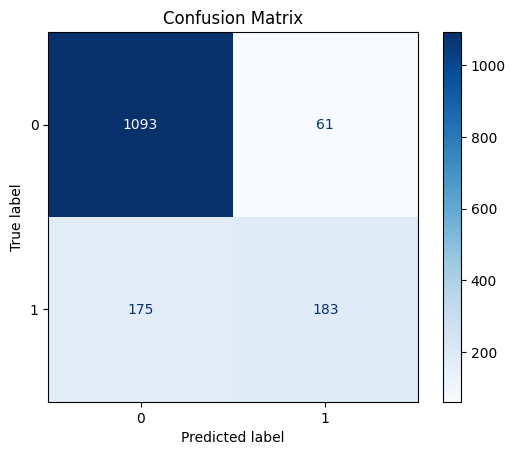

In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


# Check feature importance

In [29]:
# extract them
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

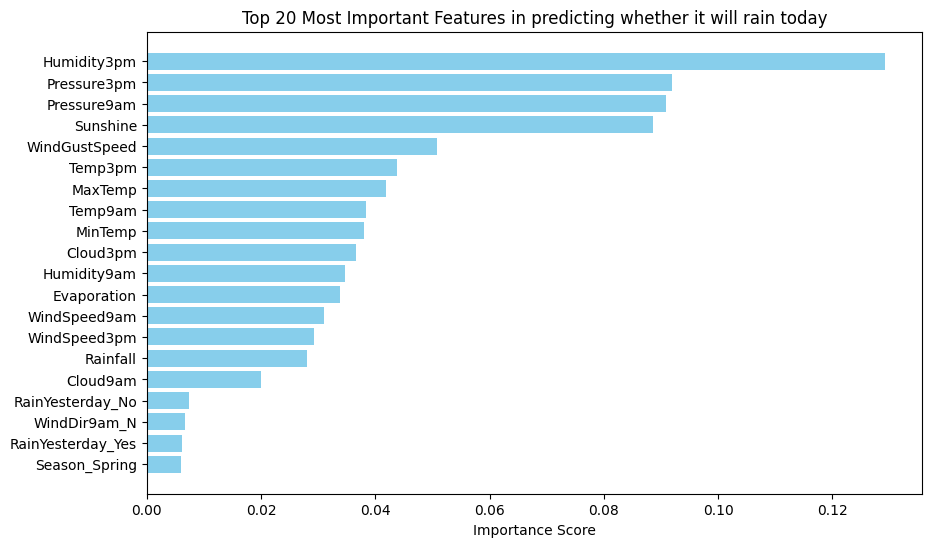

In [31]:
# dombine num and cat feature name
feature_names = numeric_features + list(grid_search.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

feature_importances = grid_search.best_estimator_['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

N = 20  # num of features
top_features = importance_df.head(N)

# plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # descending order
plt.title(f'Top {N} Most Important Features in predicting whether it will rain today')
plt.xlabel('Importance Score')
plt.show()

* Humidity3pm / Pressure3 and 9am / sunshine

# Update pipeline and parameter grid

In [34]:
# use logistic regression instead of randomforest
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
grid_search.estimator = pipeline

# define new grid with LR parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__class_weight' : [None, 'balanced']
}

grid_search.param_grid = param_grid

# fit new pipeline with LR
grid_search.fit(X_train, y_train)

# predictions
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END classifier__class_weight=None, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__solver=liblinear; total time=   0.0s


              precision    recall  f1-score   support

          No       0.86      0.93      0.89      1154
         Yes       0.69      0.51      0.59       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512



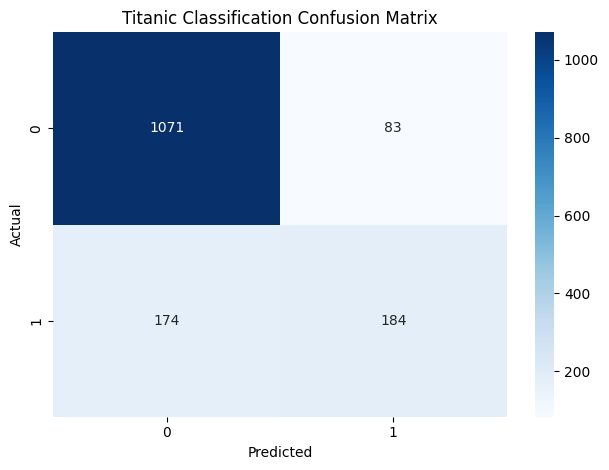

In [36]:
print(classification_report(y_test, y_pred))

# conf matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# title, labels, plot
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()